# Deep Fake Detection. EfficientNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as transforms

from torch.optim import lr_scheduler

from torch.utils.data import random_split, DataLoader
from dataset_handlers.feature_dataset import FeatureDataset

import os
from PIL import Image
from matplotlib import pyplot as plt

El modelo EfficientNetB0 es un modelo de clasificación de imágenes pre-entrenado que se puede utilizar para clasificar imágenes en 1000 clases diferentes. El modelo EfficientNetB0 tiene aproximadamente 5,3 millones de parámetros y requiere 0,4 GB de memoria. Para una descripción mas detallada del modelo, ver el paper original [aquí](https://arxiv.org/abs/1905.11946).

# Fine Tuning

Lo primero será cargar el modelo

In [3]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

Using cache found in C:\Users\carde/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


Tan solo entrenaremos de la capa 6 del modelo en adelante, ya que las primeras capas son las que detectan las formas básicas y las últimas las que detectan los patrones más abstractos. Definimos así el modelo a entrenar, modificando la capa fully connected del modelo para que éste pueda ajustarse mejor a los datos.

In [9]:
classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 2)
)

In [10]:
model = nn.Sequential(
    efficientnet.layers[6:],
    efficientnet.features,
    classifier
)

Para el entrenamiento, definimos un número de épocas, un factor de regualrización para L1 tanto para L2 y el número de folds en que dividiremos nuestro conjunto de entrenamiento para realizar validación cruzada. Utilizaremos la función de pérdida entropía cruzada y el optimizador Adam con una tasa de aprendizaje de 0.001. Para la validación, utilizaremos la métrica accuracy.

In [11]:
num_epochs = 10
l1_factor = 0.0001
l2_factor = 0.001

k_folds = 5

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_factor)

num_epochs = 10

Y ya por último, entrenamos el modelo:

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
def accuracy(data_loader, model, transform):
    acc = 0
    for i, (image, label) in enumerate(data_loader, 1):
        image = image.to(device)
        label = label.to(device)

        image = transform(image)

        output = model(image).reshape(-1, 2)
        acc += (torch.argmax(output, dim=1) == label).sum().item()

    return acc / len(data_loader.dataset)

In [15]:
def train_model(model, transform, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader):
    for epoch in range(num_epochs):
        for i, (image, label) in enumerate(train_loader, 1):
            image = image.to(device)
            label = label.to(device)

            image = transform(image)
            output = model(image)

            loss = criterion(output, label)

            l1_regularization = torch.tensor(0., requires_grad=False)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)

            l1_regularization.requires_grad_(True)
            loss += l1_factor * l1_regularization

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                acc_training_set.append(accuracy(train_loader, model, transform))
                acc_val_set.append(accuracy(val_loader, model, transform))

                print('Epoch: {:2.0f}/{}, Batch: {:2.0f}, Loss: {:.6f}, Acc (train): {:.6f}, Acc (val): {:.6f}'
                      .format(epoch+1, num_epochs, i, loss.item(), acc_training_set[-1], acc_val_set[-1]))

In [16]:
def transform_image(image):
    return image.reshape(-1, 192, 7, 7)

Para entrenar este modelo, usaremos una mezcla entre aumento de datos y cross-validation. Para ello, se dividió el conjunto de datos original en train y test. Una vez hecho eso, se generó para los datos del conjunto de train un nuevo dataset de características (ver script ```features_dataset_creator```) por cada fold. Además, a los datos de entrenamiento se les aplicó una serie de transformaciones aleatorias para conseguir así un aumento de datos, además de reducir el overfitting mediante la validación cruzada. Entrenaremos primero para tan solo **un fold**.

In [48]:
acc_training_set = []
acc_val_set = []

for fold in range(1):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_efficientnet_data_augmentation_ft/train_{fold}/")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

    train_model(model, transform_image, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch:  1/10, Batch: 10, Loss: 5.379045, Acc (train): 0.713410, Acc (val): 0.727829
Epoch:  1/10, Batch: 20, Loss: 5.253000, Acc (train): 0.721839, Acc (val): 0.724771
Epoch:  1/10, Batch: 30, Loss: 5.153671, Acc (train): 0.762452, Acc (val): 0.727829
Epoch:  1/10, Batch: 40, Loss: 5.071295, Acc (train): 0.783142, Acc (val): 0.733945
Epoch:  2/10, Batch: 10, Loss: 4.884199, Acc (train): 0.763218, Acc (val): 0.700306
Epoch:  2/10, Batch: 20, Loss: 4.736815, Acc (train): 0.808429, Acc (val): 0.737003
Epoch:  2/10, Batch: 30, Loss: 4.814573, Acc (train): 0.828352, Acc (val): 0.733945
Epoch:  2/10, Batch: 40, Loss: 4.698333, Acc (train): 0.846743, Acc (val): 0.727829
Epoch:  3/10, Batch: 10, Loss: 4.488282, Acc (train): 0.872797, Acc (val): 0.709480
Epoch:  3/10, Batch: 20, Loss: 4.391846, Acc (train): 0.857471, Acc (val): 0.770642
Epoch:  3/10, Batch: 30, Loss: 4.478344, Acc (train): 0.901149, Acc (val): 0.709480
Epoch:  3/10, Batch: 40, Loss: 4.384648, Acc (tr

In [59]:
test_dataset = FeatureDataset(f"data/splitted/test_efficientnet_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

print(f"Accuracy (test):", accuracy(test_loader, model, transform_image))

Accuracy (test): 0.7481662591687042


In [60]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for i, (image, label) in enumerate(test_loader, 1):
    image = image.to(device)
    label = label.to(device)

    image = transform_image(image)

    output = model(image).reshape(-1, 2)
    y_pred.extend(torch.argmax(output, dim=1).tolist())
    y_true.extend(label.tolist())

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[134  58]
 [ 46 171]]


Como podemos observar, el modelo es capaz de ajustarse bastante bien al conjunto de test. Este alcanza un  ```accuracy``` del 70% para el conjunto de validación, y un 74% para el de test. Para el conjunto de test, además, se obtuvo un ```recall``` del 70%, un ```f1 score``` del 72%. 

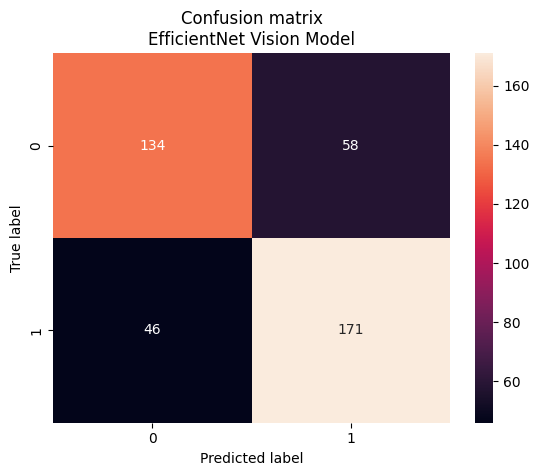

A la vista de los buenos reultados obtenidos, guardamos el modelo para su posterior uso.

In [61]:
torch.save(model.state_dict(), "models/efficientnet_ft.pth")

Entrenamos ahora para el siguiente fold:

In [62]:
acc_training_set = []
acc_val_set = []

fold = 1

print("Training model for Fold: ", fold+1)
dataset = FeatureDataset(f"data/splitted/train_efficientnet_data_augmentation_ft/train_{fold}/")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

train_model(model, transform_image, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  2
Epoch:  1/10, Batch: 10, Loss: 3.756838, Acc (train): 0.838314, Acc (val): 0.810398
Epoch:  1/10, Batch: 20, Loss: 4.175616, Acc (train): 0.847510, Acc (val): 0.773700
Epoch:  1/10, Batch: 30, Loss: 4.185228, Acc (train): 0.895019, Acc (val): 0.764526
Epoch:  1/10, Batch: 40, Loss: 3.814186, Acc (train): 0.899617, Acc (val): 0.727829
Epoch:  2/10, Batch: 10, Loss: 3.497569, Acc (train): 0.922605, Acc (val): 0.804281
Epoch:  2/10, Batch: 20, Loss: 3.601507, Acc (train): 0.950958, Acc (val): 0.795107
Epoch:  2/10, Batch: 30, Loss: 3.576423, Acc (train): 0.960153, Acc (val): 0.755352
Epoch:  2/10, Batch: 40, Loss: 3.374866, Acc (train): 0.970115, Acc (val): 0.804281
Epoch:  3/10, Batch: 10, Loss: 3.452285, Acc (train): 0.980843, Acc (val): 0.795107
Epoch:  3/10, Batch: 20, Loss: 3.407730, Acc (train): 0.978544, Acc (val): 0.807339
Epoch:  3/10, Batch: 30, Loss: 3.300605, Acc (train): 0.977778, Acc (val): 0.816514
Epoch:  3/10, Batch: 40, Loss: 3.428959, Acc (tr

In [66]:
test_dataset = FeatureDataset(f"data/splitted/test_efficientnet_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

print(f"Accuracy (test):", accuracy(test_loader, model, transform_image))

Accuracy (test): 0.7237163814180929


Parece ser que en este último fold el modelo no ha conseguido reducir su sobreajuste. Probaremos por último a entrenar el modelo con otro fold:

In [67]:
fold = 2

print("Training model for Fold: ", fold+1)
dataset = FeatureDataset(f"data/splitted/train_efficientnet_data_augmentation_ft/train_{fold}/")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

train_model(model, transform_image, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  3
Epoch:  1/10, Batch: 10, Loss: 3.324787, Acc (train): 0.870498, Acc (val): 0.840979
Epoch:  1/10, Batch: 20, Loss: 3.209246, Acc (train): 0.878161, Acc (val): 0.822630
Epoch:  1/10, Batch: 30, Loss: 3.229341, Acc (train): 0.908046, Acc (val): 0.819572
Epoch:  1/10, Batch: 40, Loss: 3.390493, Acc (train): 0.932567, Acc (val): 0.801223
Epoch:  2/10, Batch: 10, Loss: 3.074435, Acc (train): 0.957088, Acc (val): 0.822630
Epoch:  2/10, Batch: 20, Loss: 3.202864, Acc (train): 0.963985, Acc (val): 0.840979
Epoch:  2/10, Batch: 30, Loss: 3.009018, Acc (train): 0.973180, Acc (val): 0.801223
Epoch:  2/10, Batch: 40, Loss: 2.993419, Acc (train): 0.988506, Acc (val): 0.834862
Epoch:  3/10, Batch: 10, Loss: 3.038551, Acc (train): 0.990038, Acc (val): 0.840979
Epoch:  3/10, Batch: 20, Loss: 2.916192, Acc (train): 0.987739, Acc (val): 0.798165
Epoch:  3/10, Batch: 30, Loss: 2.922866, Acc (train): 0.992337, Acc (val): 0.831804
Epoch:  3/10, Batch: 40, Loss: 2.880342, Acc (tr

In [72]:
test_dataset = FeatureDataset(f"data/splitted/test_efficientnet_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

print(f"Accuracy (test):", accuracy(test_loader, model, transform_image))

Accuracy (test): 0.7041564792176039


In [76]:
y_true = []
y_pred = []

for i, (image, label) in enumerate(test_loader, 1):
    image = image.to(device)
    label = label.to(device)

    image = transform_image(image)

    output = model(image).reshape(-1, 2)
    y_pred.extend(torch.argmax(output, dim=1).tolist())
    y_true.extend(label.tolist())

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[131  61]
 [ 54 163]]


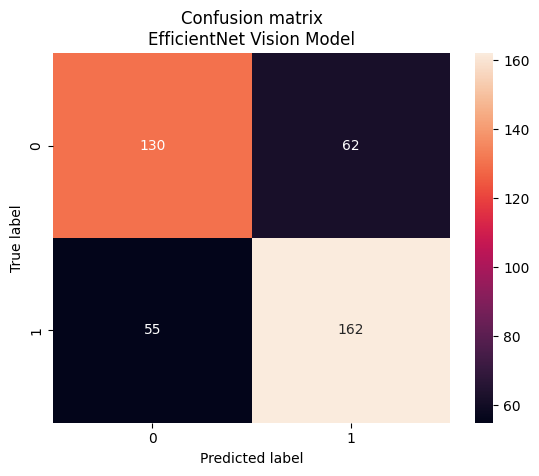

Parece ser que el modelo obtenido para un único fold es el que mejor rendimiento ha obtenido.

## ¿Y si hubieramos entrenado menos el modelo?

Probablemente el modelo haya empezado a sobreajustarse a los datos de entrenamiento antes de llegar a la décima epoch. Para comprobarlo, entrenaremos el modelo para un único fold pero con el mismo número de épocas que antes, esta vez mostrando el accuracy obtenido para el conjunto de test en cada epoch del entrenamiento

Procedemos con la creación del modelo:

In [125]:
classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

In [126]:
model_less_epochs = nn.Sequential(
    efficientnet.layers[6:],
    efficientnet.features,
    classifier
)

Para el entrenamiento, definimos un número de épocas, un factor de regualrización para L1 tanto para L2 y el número de folds en que dividiremos nuestro conjunto de entrenamiento para realizar validación cruzada. Utilizaremos la función de pérdida entropía cruzada y el optimizador Adam con una tasa de aprendizaje de 0.001. Para la validación, utilizaremos la métrica accuracy.

In [127]:
num_epochs = 20
l1_factor = 0.0001
l2_factor = 0.01

In [128]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_less_epochs.parameters(), lr=0.0001, weight_decay=l2_factor)

num_epochs = 10

Procedemos a entrenar el modelo para el primer fold:

In [129]:
acc_training_set = []
acc_val_set = []

fold = 0

print("Training model for Fold: ", fold+1)
dataset = FeatureDataset(f"data/splitted/train_efficientnet_data_augmentation_ft/train_{fold}/")
train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

test_dataset = FeatureDataset(f"data/splitted/test_efficientnet_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

train_model(model_less_epochs, transform_image, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, test_loader)

Training model for Fold:  1
Epoch:  1/10, Batch: 10, Loss: 3.193589, Acc (train): 0.944853, Acc (val): 0.709046
Epoch:  1/10, Batch: 20, Loss: 2.988772, Acc (train): 0.961397, Acc (val): 0.706601
Epoch:  1/10, Batch: 30, Loss: 2.914002, Acc (train): 0.968137, Acc (val): 0.711491
Epoch:  1/10, Batch: 40, Loss: 2.866963, Acc (train): 0.971814, Acc (val): 0.706601
Epoch:  1/10, Batch: 50, Loss: 2.879562, Acc (train): 0.974265, Acc (val): 0.687042
Epoch:  2/10, Batch: 10, Loss: 2.685781, Acc (train): 0.987745, Acc (val): 0.711491
Epoch:  2/10, Batch: 20, Loss: 2.645966, Acc (train): 0.993873, Acc (val): 0.713936
Epoch:  2/10, Batch: 30, Loss: 2.629205, Acc (train): 0.985294, Acc (val): 0.706601
Epoch:  2/10, Batch: 40, Loss: 2.576847, Acc (train): 0.994485, Acc (val): 0.696822
Epoch:  2/10, Batch: 50, Loss: 2.532907, Acc (train): 0.996936, Acc (val): 0.687042
Epoch:  3/10, Batch: 10, Loss: 2.449046, Acc (train): 0.994485, Acc (val): 0.696822
Epoch:  3/10, Batch: 20, Loss: 2.442044, Acc (tr

Parece no haber mucha mejora entre la décima epoch y las anteriores.

# Aumento Masivo de Datos

Antes los resultados obtenidos por el modelo anterior, decidimos probar con un aumento masivo de datos, de la mano nuevamente del cross-validation. Para ello, hemos triplicado el tamaño del conjunto de entrenamiento en cada fold, además de mantener las transformaciones aleatorias entre los distintos folds sobre los datos de entrenamiento originales. El conjunto de test, por el contrario, ha permanecido intacto.

Procedemos con la creación del modelo:

In [17]:
classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

In [18]:
model_mda = nn.Sequential(
    efficientnet.layers[6:],
    efficientnet.features,
    classifier
)

Para el entrenamiento, definimos un número de épocas, un factor de regualrización para L1 tanto para L2 y el número de folds en que dividiremos nuestro conjunto de entrenamiento para realizar validación cruzada. Utilizaremos la función de pérdida entropía cruzada y el optimizador Adam con una tasa de aprendizaje de 0.001. Para la validación, utilizaremos la métrica accuracy.

In [19]:
num_epochs = 10
l1_factor = 0.0001
l2_factor = 0.01

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mda.parameters(), lr=0.0001, weight_decay=l2_factor)

Procedemos a entrenar el modelo para el primer fold:

In [21]:
acc_training_set = []
acc_val_set = []

fold = 0

print("Training model for Fold: ", fold+1)
dataset = FeatureDataset(f"data/splitted/train_efficientnet_massive_data_augmentation_ft/train_{fold}/")
train_loader = DataLoader(dataset=dataset, batch_size=250, shuffle=True)

test_dataset = FeatureDataset(f"data/splitted/test_efficientnet_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

train_model(model_mda, transform_image, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, test_loader)

Training model for Fold:  1
Epoch:  1/10, Batch: 10, Loss: 9.004392, Acc (train): 0.561479, Acc (val): 0.577017
Epoch:  1/10, Batch: 20, Loss: 8.831636, Acc (train): 0.549632, Acc (val): 0.542787
Epoch:  2/10, Batch: 10, Loss: 8.681262, Acc (train): 0.563521, Acc (val): 0.547677
Epoch:  2/10, Batch: 20, Loss: 8.521671, Acc (train): 0.619894, Acc (val): 0.601467
Epoch:  3/10, Batch: 10, Loss: 8.364111, Acc (train): 0.615400, Acc (val): 0.589242
Epoch:  3/10, Batch: 20, Loss: 8.216187, Acc (train): 0.653799, Acc (val): 0.623472
Epoch:  4/10, Batch: 10, Loss: 8.067754, Acc (train): 0.664011, Acc (val): 0.613692
Epoch:  4/10, Batch: 20, Loss: 7.934400, Acc (train): 0.654616, Acc (val): 0.608802
Epoch:  5/10, Batch: 10, Loss: 7.785292, Acc (train): 0.669322, Acc (val): 0.603912
Epoch:  5/10, Batch: 20, Loss: 7.640598, Acc (train): 0.673815, Acc (val): 0.635697
Epoch:  6/10, Batch: 10, Loss: 7.531450, Acc (train): 0.684436, Acc (val): 0.628362
Epoch:  6/10, Batch: 20, Loss: 7.385005, Acc (tr

En vista de los malos resultados obtenidos, decidimos probar con otro fold:

In [22]:
acc_training_set = []
acc_val_set = []

fold = 1

print("Training model for Fold: ", fold+1)
dataset = FeatureDataset(f"data/splitted/train_efficientnet_massive_data_augmentation_ft/train_{fold}/")
train_loader = DataLoader(dataset=dataset, batch_size=250, shuffle=True)

test_dataset = FeatureDataset(f"data/splitted/test_efficientnet_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

train_model(model_mda, transform_image, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, test_loader)

Training model for Fold:  2
Epoch:  1/10, Batch: 10, Loss: 6.410676, Acc (train): 0.719975, Acc (val): 0.667482
Epoch:  1/10, Batch: 20, Loss: 6.350513, Acc (train): 0.732843, Acc (val): 0.660147
Epoch:  2/10, Batch: 10, Loss: 6.191731, Acc (train): 0.742443, Acc (val): 0.674817
Epoch:  2/10, Batch: 20, Loss: 6.161307, Acc (train): 0.751838, Acc (val): 0.667482
Epoch:  3/10, Batch: 10, Loss: 6.064075, Acc (train): 0.760212, Acc (val): 0.647922
Epoch:  3/10, Batch: 20, Loss: 5.958786, Acc (train): 0.774918, Acc (val): 0.682152
Epoch:  4/10, Batch: 10, Loss: 5.885881, Acc (train): 0.773897, Acc (val): 0.682152
Epoch:  4/10, Batch: 20, Loss: 5.822662, Acc (train): 0.777778, Acc (val): 0.672372
Epoch:  5/10, Batch: 10, Loss: 5.685838, Acc (train): 0.802492, Acc (val): 0.682152
Epoch:  5/10, Batch: 20, Loss: 5.622914, Acc (train): 0.811479, Acc (val): 0.696822
Epoch:  6/10, Batch: 10, Loss: 5.533569, Acc (train): 0.819240, Acc (val): 0.679707
Epoch:  6/10, Batch: 20, Loss: 5.463994, Acc (tr

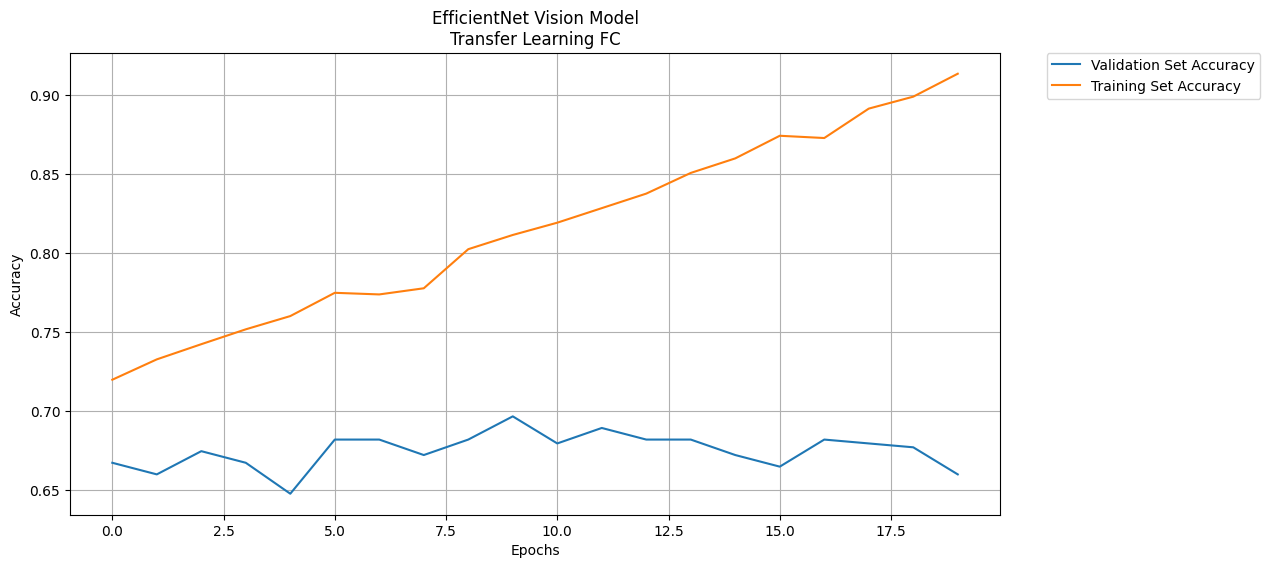

Puede apreciarse como, debido a haber aumentado el factor de penalización L2, el modelo tarda más en sobreajustarse a los datos de entrenamiento. Sin embargo, el modelo sigue sin ser capaz de generalizar bien a los datos de test.

Si entrenamos para un último fold:

In [25]:
acc_training_set = []
acc_val_set = []

fold = 2

print("Training model for Fold: ", fold+1)
dataset = FeatureDataset(f"data/splitted/train_efficientnet_massive_data_augmentation_ft/train_{fold}/")
train_loader = DataLoader(dataset=dataset, batch_size=250, shuffle=True)

test_dataset = FeatureDataset(f"data/splitted/test_efficientnet_ft/test")
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

train_model(model_mda, transform_image, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, test_loader)

Training model for Fold:  3
Epoch:  1/10, Batch: 10, Loss: 4.954699, Acc (train): 0.835784, Acc (val): 0.694377
Epoch:  1/10, Batch: 20, Loss: 4.846735, Acc (train): 0.858864, Acc (val): 0.652812
Epoch:  2/10, Batch: 10, Loss: 4.747049, Acc (train): 0.877655, Acc (val): 0.662592
Epoch:  2/10, Batch: 20, Loss: 4.748132, Acc (train): 0.899101, Acc (val): 0.672372
Epoch:  3/10, Batch: 10, Loss: 4.602305, Acc (train): 0.910948, Acc (val): 0.665037
Epoch:  3/10, Batch: 20, Loss: 4.596317, Acc (train): 0.920956, Acc (val): 0.677262
Epoch:  4/10, Batch: 10, Loss: 4.518649, Acc (train): 0.933415, Acc (val): 0.682152
Epoch:  4/10, Batch: 20, Loss: 4.472551, Acc (train): 0.940768, Acc (val): 0.647922
Epoch:  5/10, Batch: 10, Loss: 4.410339, Acc (train): 0.950368, Acc (val): 0.655257
Epoch:  5/10, Batch: 20, Loss: 4.306159, Acc (train): 0.960172, Acc (val): 0.647922
Epoch:  6/10, Batch: 10, Loss: 4.264802, Acc (train): 0.966708, Acc (val): 0.640587
Epoch:  6/10, Batch: 20, Loss: 4.232508, Acc (tr